# Projeto: Previsão de Preços de Imóveis em Ames

### Importação das Bibliotecas Necessárias

In [ ]:
# Importação das bibliotecas essenciais
import pickle
import pandas as pd
from pathlib import Path

# Importação das bibliotecas de pré-processamento e modelagem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Importação dos modelos de regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Importação das métricas de avaliação
from sklearn.metrics import mean_squared_error, r2_score

# Importação para visualização dos resultados
import matplotlib.pyplot as plt
import seaborn as sns

### Carregamento dos Dados Processados

In [ ]:
# Definição do caminho para o arquivo processado
DATA_DIR = Path.cwd().parent / 'data'
processed_file_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

# Carregamento dos dados processados
with open(processed_file_path, 'rb') as file:
    data = pickle.load(file)

### Divisão dos Dados em Conjuntos de Treinamento e Teste

In [163]:
# Definição da variável alvo
y = data['SalePrice']

# Definição das variáveis preditoras
X = data.drop('SalePrice', axis=1)

# Divisão dos dados em treinamento e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Identificação das Colunas Categóricas e Numéricas

In [164]:
# Identificação das colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Colunas Categóricas: {categorical_cols}")
print(f"Colunas Numéricas: {numerical_cols}")

Colunas Categóricas: ['MS.SubClass', 'MS.Zoning', 'Lot.Shape', 'Land.Contour', 'Lot.Config', 'Land.Slope', 'Neighborhood', 'Bldg.Type', 'House.Style', 'Overall.Qual', 'Overall.Cond', 'Roof.Style', 'Mas.Vnr.Type', 'Exter.Qual', 'Exter.Cond', 'Foundation', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure', 'BsmtFin.Type.1', 'BsmtFin.Type.2', 'Heating.QC', 'Central.Air', 'Electrical', 'Kitchen.Qual', 'Functional', 'Garage.Type', 'Garage.Finish', 'Paved.Drive', 'Fence', 'Sale.Type', 'Sale.Condition', 'Condition', 'Exterior']
Colunas Numéricas: ['Lot.Frontage', 'Lot.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Gr.Liv.Area', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Full.Bath', 'Half.Bath', 'Bedroom.AbvGr', 'Kitchen.AbvGr', 'TotRms.AbvGrd', 'Fireplaces', 'Garage.Cars', 'Garage.Area', 'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val', 'Mo.Sold', 'Yr.Sold', 'Ga

### Conversão das Colunas Categóricas para Strings

In [165]:
# Converter todas as colunas categóricas para string para evitar erros no encoder
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Verificação para garantir que a conversão foi bem-sucedida
print(X_train[categorical_cols].dtypes)
print(X_test[categorical_cols].dtypes)

MS.SubClass       object
MS.Zoning         object
Lot.Shape         object
Land.Contour      object
Lot.Config        object
Land.Slope        object
Neighborhood      object
Bldg.Type         object
House.Style       object
Overall.Qual      object
Overall.Cond      object
Roof.Style        object
Mas.Vnr.Type      object
Exter.Qual        object
Exter.Cond        object
Foundation        object
Bsmt.Qual         object
Bsmt.Cond         object
Bsmt.Exposure     object
BsmtFin.Type.1    object
BsmtFin.Type.2    object
Heating.QC        object
Central.Air       object
Electrical        object
Kitchen.Qual      object
Functional        object
Garage.Type       object
Garage.Finish     object
Paved.Drive       object
Fence             object
Sale.Type         object
Sale.Condition    object
Condition         object
Exterior          object
dtype: object
MS.SubClass       object
MS.Zoning         object
Lot.Shape         object
Land.Contour      object
Lot.Config        object
Land.Slope 

In [ ]:
def percentage_error(y_true, y_pred):
    """Calcula o Erro Percentual Absoluto Médio (PEA).

    Args:
        y_true (array-like): Valores reais.
        y_pred (array-like): Valores previstos.

    Returns:
        float: PEA em porcentagem.
    """
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    # Evitar divisão por zero substituindo zeros por um pequeno valor
    y_true = y_true.replace(0, 1e-10)
    return (abs((y_true - y_pred) / y_true).mean()) * 100

### Definição das Pipelines de Pré-processamento

In [ ]:
# Pipeline para variáveis numéricas
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para variáveis categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinação das pipelines usando ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

### Definição dos Modelos

In [ ]:
# Definição dos modelos a serem comparados com seus hiperparâmetros
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5],
            'regressor__min_samples_leaf': [1, 2]
        }
    }
}

### Criação das Pipelines de Modelos

In [ ]:
# Criação das pipelines e configuração do GridSearchCV
pipelines = {}
for name, config in models.items():
    # Pipeline para cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    # GridSearchCV para otimização de hiperparâmetros
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    pipelines[name] = grid_search

### Treinamento dos Modelos

In [ ]:
# Treinamento de cada modelo com GridSearchCV
for name, grid_search in pipelines.items():
    try:
        print(f"Iniciando treinamento do modelo: {name}")
        grid_search.fit(X_train, y_train)
        print(f"{name} treinado com sucesso.\n")
    except Exception as e:
        print(f"Erro ao treinar {name}: {e}\n")

Iniciando treinamento do modelo: Linear Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Linear Regression treinado com sucesso.
Iniciando treinamento do modelo: Ridge Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Regression treinado com sucesso.
Iniciando treinamento do modelo: Lasso Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Lasso Regression treinado com sucesso.
Iniciando treinamento do modelo: Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Random Forest treinado com sucesso.


### Avaliação e Comparação dos Modelos

In [ ]:
# Avaliação dos modelos no conjunto de teste
results = []

for name, grid_search in pipelines.items():
    try:
        # Previsões
        y_pred = grid_search.predict(X_test)
        
        # Cálculo das métricas
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        percent_error = percentage_error(y_test, y_pred)
        
        # Coleta dos melhores hiperparâmetros
        best_params = grid_search.best_params_
        
        # Armazenamento dos resultados
        results.append({
            'Modelo': name,
            'Melhores Hiperparâmetros': best_params,
            'R²': r2,
            'RMSE': rmse,
            'Erro Percentual (%)': round(percent_error, 2)
        })
        
        print(f"{name} avaliado com sucesso.")
    except Exception as e:
        print(f"Erro ao avaliar {name}: {e}")

# Conversão da lista de resultados para DataFrame
results_df = pd.DataFrame(results)

# Exibição dos resultados ordenados por Erro Percentual
print(results_df.sort_values(by='Erro Percentual (%)'))

Linear Regression avaliado com sucesso.
Ridge Regression avaliado com sucesso.
Lasso Regression avaliado com sucesso.
Random Forest avaliado com sucesso.
              Modelo                           Melhores Hiperparâmetros  \
2   Lasso Regression                         {'regressor__alpha': 0.01}   
3      Random Forest  {'regressor__max_depth': None, 'regressor__min...   
1   Ridge Regression                          {'regressor__alpha': 1.0}   
0  Linear Regression                                                 {}   

         R²      RMSE  MAPE (%)  
2  0.772645  0.081932  3.743629  
3  0.886171  0.057974  3.948765  
1  0.884028  0.058517  4.110073  
0  0.880802  0.059325  4.116497  


c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarnin

### Visualização dos Resultados

C:\Users\gabri\AppData\Local\Temp\ipykernel_16176\4040038594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modelo', data=results_df.sort_values('RMSE', ascending=True), palette='viridis')


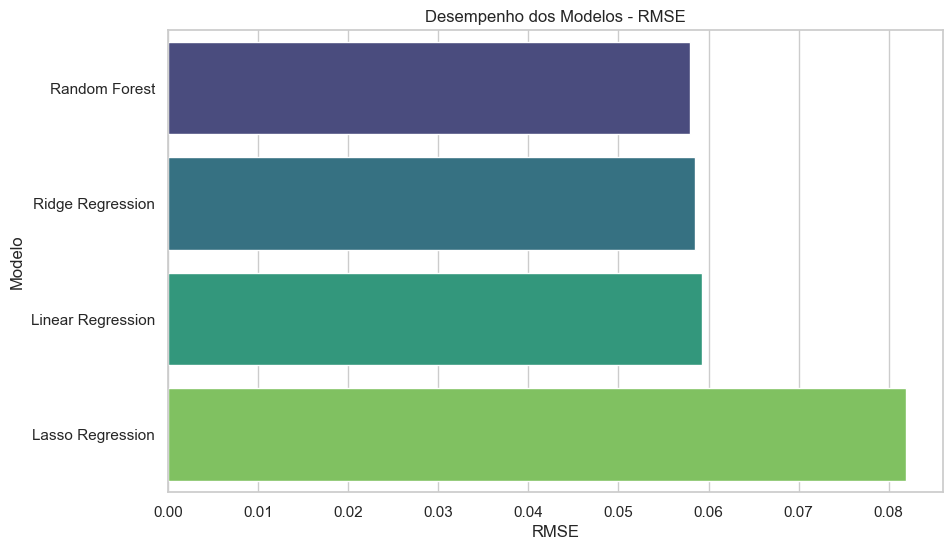

C:\Users\gabri\AppData\Local\Temp\ipykernel_16176\4040038594.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAPE (%)', y='Modelo', data=results_df.sort_values('MAPE (%)', ascending=True), palette='magma')


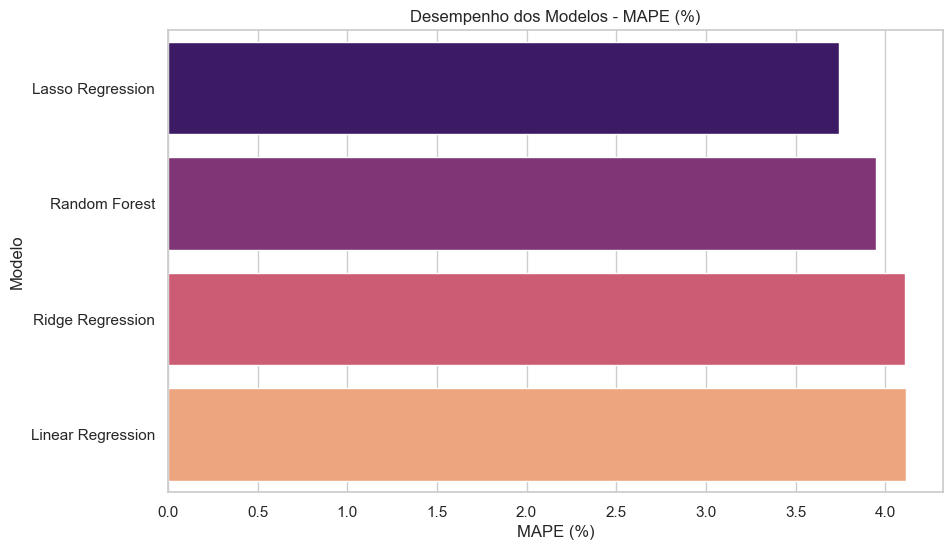

In [ ]:
# Configuração do estilo dos gráficos
sns.set_theme(style="whitegrid")

# Gráfico de barras para RMSE
plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Modelo', data=results_df.sort_values('RMSE', ascending=True), palette='viridis')
plt.title('Desempenho dos Modelos - RMSE')
plt.xlabel('RMSE')
plt.ylabel('Modelo')
plt.show()

# Gráfico de barras para Erro Percentual
plt.figure(figsize=(10,6))
sns.barplot(x='Erro Percentual (%)', y='Modelo', data=results_df.sort_values('Erro Percentual (%)', ascending=True), palette='magma')
plt.title('Desempenho dos Modelos - Erro Percentual (%)')
plt.xlabel('Erro Percentual (%)')
plt.ylabel('Modelo')
plt.show()

In [ ]:
# Identificação do modelo com menor Erro Percentual
best_model = results_df.loc[results_df['Erro Percentual (%)'].idxmin()]

print("Modelo com menor erro percentual (Erro Percentual):")
print(f"Modelo: {best_model['Modelo']}")
print(f"Melhores Hiperparâmetros: {best_model['Melhores Hiperparâmetros']}")
print(f"R²: {best_model['R²']:.4f}")
print(f"RMSE: {best_model['RMSE']:.2f}")
print(f"Erro Percentual: {best_model['Erro Percentual (%)']}%")

Modelo com menor erro percentual (MAPE):
Modelo                                Lasso Regression
Melhores Hiperparâmetros    {'regressor__alpha': 0.01}
R²                                            0.772645
RMSE                                          0.081932
MAPE (%)                                      3.743629
Name: 2, dtype: object


### Considerações Finais

In [ ]:
# Exibição dos resultados de forma mais detalhada
display(results_df.sort_values(by='Erro Percentual (%)', ascending=True))

,Modelo,Melhores Hiperparâmetros,R²,RMSE,MAPE (%)
2,Lasso Regression,{'regressor__alpha': 0.01},0.772645,0.081932,3.743629
3,Random Forest,"{'regressor__max_depth': None, 'regressor__min...",0.886171,0.057974,3.948765
1,Ridge Regression,{'regressor__alpha': 1.0},0.884028,0.058517,4.110073
0,Linear Regression,{},0.880802,0.059325,4.116497
